In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath
import utils

In [2]:
# Wrapper for southern ocean map
def plt_SO(max_lat=-45, central_longitude=-100):
    """Configure polar stereographic projection for Southern Ocean.
    In particular, sets extent of axis and cuts a circular boundary.
    Returns figure and axis handles into which you can plot.
    
    Parameters
    ----------
    max_lat : float, int
        Northernmost latitude in degN
    central_longitude : float, int
        Longitude to place at top of figure
    
    Returns
    -------
    fig : mpl figure handle
    ax : mpl axis handle
    """
    fig,ax = plt.subplots(figsize=(20,10),
                      subplot_kw={'projection':
                                      ccrs.SouthPolarStereo(
                                      central_longitude=-100)})
    ax.set_extent([-180, 180, -90, max_lat], ccrs.PlateCarree())
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # Add some details
    ax.add_feature(cfeature.LAND, zorder=10,facecolor='lightgray')
    ax.gridlines()
    
    return fig,ax

In [3]:
locinit = "Drake-upstream"
timedir = "forw"
runtime = 10*365 # days

fileout = ("output"
           +".locinit_"+locinit
           +".timedir_"+timedir
           +".ntime_"+str(runtime)+".nc")

ds = xr.open_dataset(fileout)

ds['init_lon'] = ds['lon'].isel(obs=0)*xr.ones_like(ds['lon'])
ds['init_lat'] = ds['lat'].isel(obs=0)*xr.ones_like(ds['lat'])
ds['init_z'] = ds['z'].isel(obs=0)*xr.ones_like(ds['z'])
ds['init_T'] = ds['T'].isel(obs=0)*xr.ones_like(ds['T'])
ds['init_S'] = ds['S'].isel(obs=0)*xr.ones_like(ds['S'])

dsC = 0.5*(ds.drop('time')
           +ds.drop('time').roll({'obs':1},roll_coords=False)
          ).isel(obs=slice(1,1000)) # Hard coding upper limit
dsC['dlon'] = ds['lon'].diff('obs')
dsC['dlat'] = ds['lat'].diff('obs')
dsC['dx'],dsC['dy'] = utils.geo._degrees_to_meters(
    dsC['dlon'],dsC['dlat'],dsC['lon'],dsC['lat'])

# dx = np.concatenate((np.zeros(len(ds['traj'])),dsC['dx']))
# ds['x'] = ds['lon'].copy(data=dx).cumsum('obs')

### Pathways from different starting longitudes

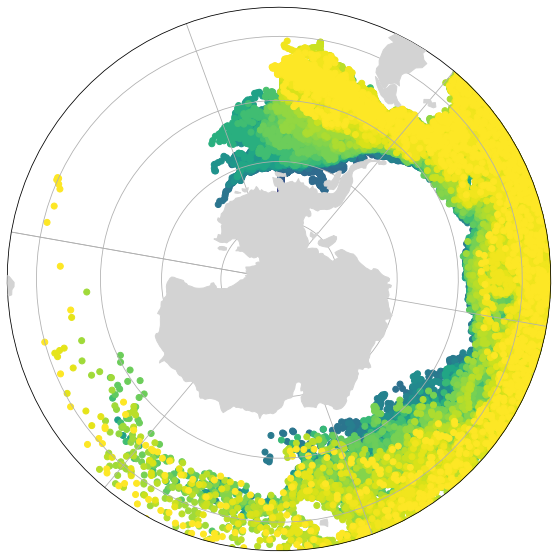

In [11]:
iselect = {'obs':slice(0,6*12)}
fig,ax=plt_SO()
dsnow = ds.where(ds['init_lon']==261,drop=True).isel(**iselect)
ax.scatter(dsnow['lon'],dsnow['lat'],c=dsnow['init_lat'],transform=ccrs.PlateCarree())

### Properties at Drake passage

In [12]:
# Histogram in depth and latitude and pick out Drake Passage latitudes
bins_initlon = np.arange(200,300,10)
bins_depth = np.arange(-5000,0,100)
bins_lat = np.arange(-70,-55,1)
bins_lon = np.array([290,292])

prop = 'init_z'
hs_n = histogram(ds['init_lon'],ds['z'],ds['lat'],ds['lon'],bins=[bins_initlon,bins_depth,bins_lat,bins_lon]).squeeze()
hs_prop = histogram(ds['init_lon'],ds['z'],ds['lat'],ds['lon'],bins=[bins_initlon,bins_depth,bins_lat,bins_lon],weights=ds[prop]).squeeze()

hs_n = hs_n.where(hs_n!=0,np.nan)
hs_prop = hs_prop.where(hs_prop!=0,np.nan)

hs_ave = hs_prop/hs_n

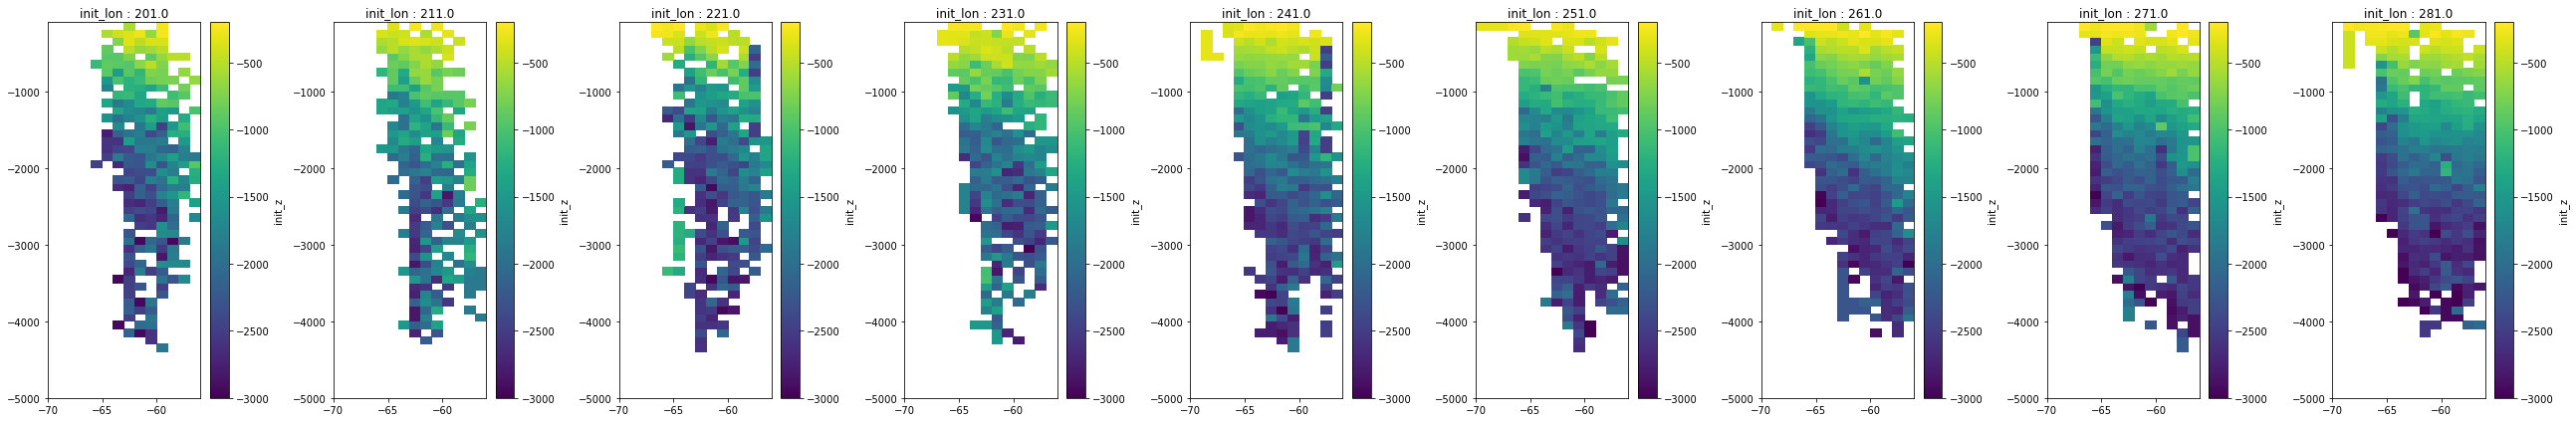

In [13]:
n = len(hs_ave['init_lon_bin'])
if prop == 'init_z':
    clims = [-3000,-200]
elif prop == 'init_lat':
    clims = [-75,-55]
    
fig,axarr = plt.subplots(figsize=(n*4,6),ncols=n)
for i in range(n):
    axnow = axarr.flat[i]
    danow = hs_ave.isel({'init_lon_bin':i})
    im = axnow.pcolormesh(danow['lat_bin'],danow['z_bin'],danow,shading='auto')
    im.set_clim(clims)
    cb = plt.colorbar(im,ax=axnow)
    cb.set_label(prop)
    axnow.set_title('init_lon : '+str(danow['init_lon_bin'].values-4))
fig.tight_layout()
fig.savefig('figures/prop-at-Drake.'+prop+'.png',dpi=300,transparent=True)

### Look at specific latitude bands

In [8]:
loncond = (ds['lon']<292) & (ds['lon']>290)
latcond = (ds['lat']<-63) & (ds['lat']>-65)
zcond = (ds['z']<-1000) & (ds['z']>-2000)
dsnow = ds.where((loncond) & (latcond) & (zcond),drop=True)
dsnow

<xarray.Dataset>
Dimensions:     (obs: 119, traj: 862)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 nan nan nan nan nan ... nan nan nan nan nan
    time        (traj, obs) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    lat         (traj, obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    lon         (traj, obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    z           (traj, obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    T           (traj, obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    S           (traj, obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    MLD         (traj, obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    init_lon    (traj, obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    init_lat    (traj, obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    init_z      (traj, obs) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.0
    parcels_mesh:           spherical

In [9]:
bins_initlon = np.arange(200,300,10)
bins_initlat = np.arange(-80,-55,1)
hs = histogram(dsnow['init_lon'],dsnow['init_lat'],bins=[bins_initlon,bins_initlat])
hsnorm = hs/hs.sum('init_lat_bin')

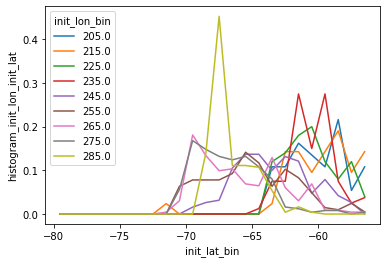

In [10]:
hsnorm.plot(hue='init_lon_bin');

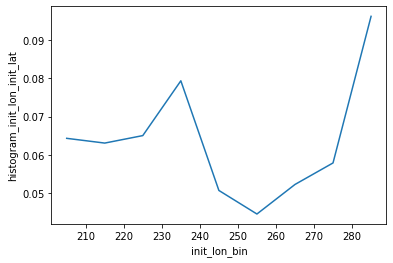

In [11]:
hsnorm.std('init_lat_bin').plot()

In [40]:
tmp = np.unique(dsnow['init_lat'])
init = tmp[~np.isnan(tmp)]
init

array([-71.32653 , -70.81633 , -70.30612 , -69.79592 , -69.28571 ,
       -68.77551 , -68.265305, -67.755104, -67.244896, -66.734695,
       -66.22449 , -65.71429 , -65.20408 , -64.69388 , -64.18367 ,
       -63.67347 , -63.163265, -62.65306 , -62.142857, -61.632652,
       -61.122448, -60.612244, -60.10204 , -59.591835, -59.081635,
       -58.57143 , -58.061226, -57.55102 , -57.040817, -56.530613,
       -56.02041 , -55.510204, -55.      ], dtype=float32)

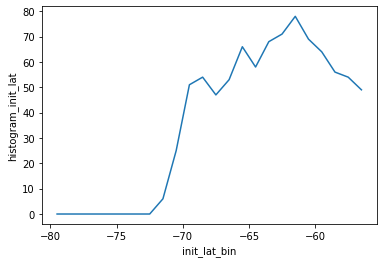

In [31]:
loncond = (ds['lon']<292) & (ds['lon']>290)
initloncond = ds['init_lon']==261
dsnow = ds.where((loncond)&(initloncond),drop=True)
initlat = dsnow['init_lat'].mean('obs',skipna=True)
initlat_bins = np.arange(-80,-55,1)
hs = histogram(initlat,bins=[initlat_bins])
hs.plot()

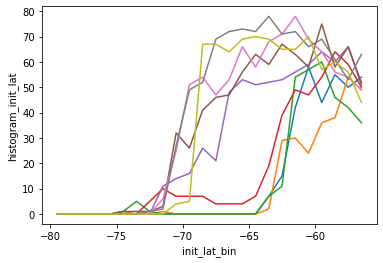

In [36]:
loncond = (ds['lon']<292) & (ds['lon']>290)
tmp = np.unique(ds['init_lon'])
init = tmp[~np.isnan(tmp)]
for lon in init:
    
    initloncond = ds['init_lon']==lon
    dsnow = ds.where((loncond)&(initloncond),drop=True)
    initlat = dsnow['init_lat'].mean('obs',skipna=True)
    initlat_bins = np.arange(-80,-55,1)
    hs = histogram(initlat,bins=[initlat_bins])
    hs.plot()

In [35]:
ds

<xarray.Dataset>
Dimensions:     (obs: 123, traj: 22500)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 -80.0 -80.0 nan ... -57.630234 -58.64658
    lon         (traj, obs) float32 201.0 201.0 nan ... 61.407764 63.323975
    z           (traj, obs) float32 -200.0 -200.0 nan ... -983.73584 -1012.90375
    T           (traj, obs) float32 ...
    S           (traj, obs) float32 ...
    MLD         (traj, obs) float32 ...
    init_lon    (traj, obs) float32 201.0 201.0 201.0 ... 281.0 281.0 281.0
    init_lat    (traj, obs) float32 -80.0 -80.0 -80.0 ... -55.0 -55.0 -55.0
    init_z      (traj, obs) float32 -200.0 -200.0 -200.0 ... -3000.0 -3000.0
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.0
    parcels_mesh:           spherical

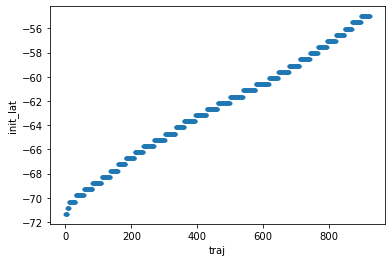

In [30]:
dsnow['init_lat'].mean('obs',skipna=True).plot(linestyle='',marker='.')

### Properties along path

In [108]:
iselect = {'obs':slice(0,8*12)}
# Find particles that pass through Drake
loncond = (ds['lon']<292) & (ds['lon']>290)
drake = loncond.sum('obs')>=1
dsdrake = ds.isel(traj=drake).isel(**iselect)
# Now get the ones that started at a specific longitude
lon = 201
initloncond = dsdrake['init_lon']==lon
dsnow = dsdrake.where(initloncond,drop=True)
# Now set to nan after they pass through DP
firstpass = (dsnow['lon']<292) & (dsnow['lon']>lon)
dsnow = dsnow.where(firstpass)

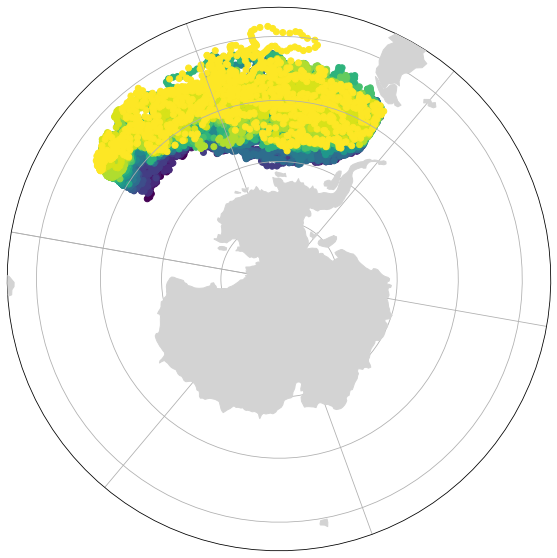

In [109]:
fig,ax=plt_SO()
ax.scatter(dsnow['lon'],dsnow['lat'],c=dsnow['init_lat'],transform=ccrs.PlateCarree())

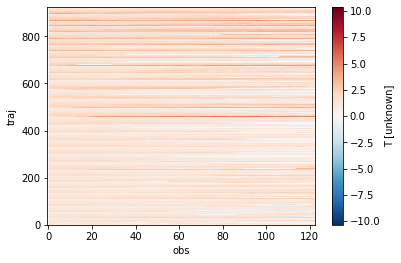

In [61]:
dsnow['T'].plot()

### Ideas
- [ ] Take larger boxes, with multiple particles present, and plot histograms of their initial latitude, showing the spread of the histogram increasing as the initial longitude is further and further west.
- [ ] Calculate meridional displacement (or average meridional displacement) of particles along path?
- [ ] I could actually stop the particles as they pass through DP in the original simulation

In [22]:
dsnow['init_lon'].where(~np.isnan(dsnow['init_lon']))

<xarray.DataArray 'init_lon' (traj: 862, obs: 119)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Dimensions without coordinates: traj, obs

In [18]:
dsnow

<xarray.Dataset>
Dimensions:     (obs: 119, traj: 991)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 nan nan nan nan nan ... nan nan nan nan nan
    time        (traj, obs) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    lat         (traj, obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    lon         (traj, obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    z           (traj, obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    T           (traj, obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    S           (traj, obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    MLD         (traj, obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    init_lon    (traj, obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    init_lat    (traj, obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    init_z      (traj, obs) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.0
    parcels_mesh:           spherical